## Failure ratio of master jobs
Jobs initiated in an interval of one hour over the last 14 days

In [1]:
%matplotlib inline
import sys
import os
import datetime, calendar
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [3]:
from datetime import datetime, timedelta
now = datetime.now()
one_hour = timedelta(hours=1)
    
# Number of days we want to go back in
hours_in_past = 338
    
reversed_last_hours = list(
    map(
        lambda i: (now - (i * one_hour)).isoformat(),
        range(hours_in_past + 1)
    )
)

last_hours = reversed_last_hours[::-1]

first_hour, *tail_hours = last_hours

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(first_hour)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

In [4]:
def hour_builds(hour_df):
    return pd.DataFrame(
        hour_df
            .sort_values(by='stage_timestamp')
            .drop_duplicates('job_name', keep='last')
    )

def hour_df(frame, hour_number):
    return frame[
        (frame['stage_timestamp'] > last_hours[hour_number])
        & (frame['stage_timestamp'] < last_hours[hour_number + 1])
    ]

builds = list(
    map(
        lambda hour_number: hour_builds(hour_df(df, hour_number)),
        list(range(len(last_hours) - 1))
    )
)

In [5]:
def hour_stats(i, current_build):
    total_rows = len(current_build)
    successes = len(current_build.loc[df['current_build_current_result'] == 'SUCCESS'])
    failures = len(current_build.loc[df['current_build_current_result'] == 'FAILURE'])
    aborted = len(current_build.loc[df['current_build_current_result'] == 'ABORTED'])
    unknows = total_rows - successes - failures - aborted
    total = successes + failures + aborted
    success_ratio = 100 if total == 0 else round(successes/total * 100)
    
    return ({
        "success ratio": success_ratio,
        "stats": [successes, failures, aborted, unknows],
        "stats_labels": ['SUCCESS', 'FAILURE', 'ABORTED', 'UNKNOWN'],
        "date": { "from": last_hours[i], "to" : last_hours[i+1] }
    })

all_hours_stats = [hour_stats(i,x) for i,x in enumerate(builds)]

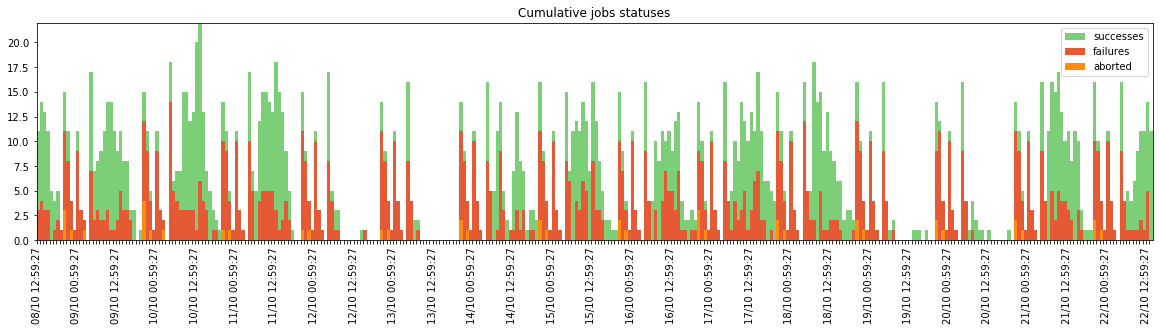

In [32]:
colors = {
    'aborted': '#FF8C11',
    'failures': '#E55934',
    'successes': '#7CCE77',
}

horizontal_axis_labels = list(
    map(
        lambda all_hours_stats: datetime.fromisoformat(all_hours_stats['date']['from']).strftime('%d/%m %H:%M:%S'), 
        all_hours_stats
    )
)

data = {
    'successes': [0 if sum(item['stats']) == 0 else item['stats'][0] for item in all_hours_stats],
    'failures':  [0 if sum(item['stats']) == 0 else item['stats'][1] for item in all_hours_stats],
    'aborted':   [0 if sum(item['stats']) == 0 else item['stats'][2] for item in all_hours_stats],
}

fig, ax = plt.subplots()
fig.set_size_inches(20, 4)

ax.set_title('Cumulative jobs statuses')
ax.margins(0)

p_aborted = plt.bar(list(range(hours_in_past)), data['aborted'], linewidth=2, color=colors['aborted'], align='edge', width=1)
p_failures = plt.bar(list(range(hours_in_past)), data['failures'], linewidth=2, color=colors['failures'], align='edge', width=1, bottom=[data['aborted'][j] for j in range(len(data['successes']))])
p_success = plt.bar(list(range(hours_in_past)), data['successes'], linewidth=2, color=colors['successes'], align='edge', width=1, bottom=[data['failures'][j] + data['aborted'][j] for j in range(len(data['successes']))])
plt.xticks(range(hours_in_past), horizontal_axis_labels, rotation='vertical')
plt.legend((p_success[0], p_failures[0], p_aborted[0]), ('successes', 'failures', 'aborted'))

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.show()

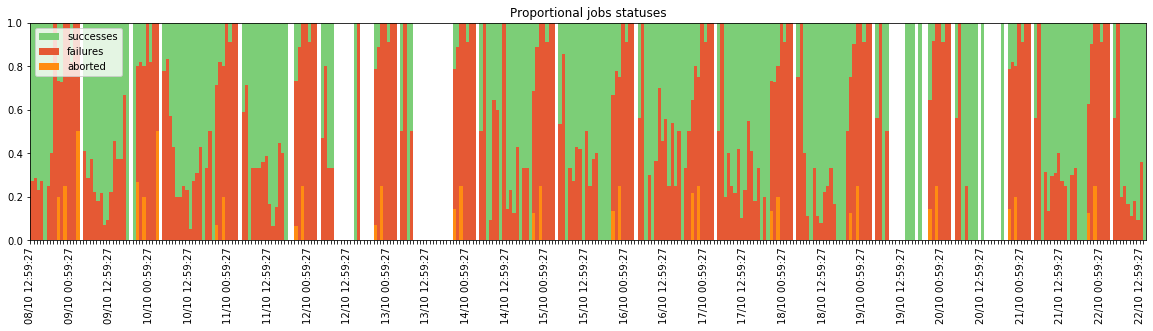

In [33]:
data_ratio = {
    'successes': [0 if sum(item['stats']) == 0 else (item['stats'][0]/sum(item['stats'])) for item in all_hours_stats],
    'failures':  [0 if sum(item['stats']) == 0 else (item['stats'][1]/sum(item['stats'])) for item in all_hours_stats],
    'aborted':   [0 if sum(item['stats']) == 0 else (item['stats'][2]/sum(item['stats'])) for item in all_hours_stats],
}

fig, ax = plt.subplots()
fig.set_size_inches(20, 4)

ax.set_title('Proportional jobs statuses')
ax.margins(0)

p_aborted = plt.bar(list(range(hours_in_past)), data_ratio['aborted'], linewidth=2, color=colors['aborted'], align='edge', width=1)
p_failures = plt.bar(list(range(hours_in_past)), data_ratio['failures'], linewidth=2, color=colors['failures'], align='edge', width=1, bottom=[data_ratio['aborted'][j] for j in range(len(data_ratio['successes']))])
p_success = plt.bar(list(range(hours_in_past)), data_ratio['successes'], linewidth=2, color=colors['successes'], align='edge', width=1, bottom=[data_ratio['failures'][j] + data_ratio['aborted'][j] for j in range(len(data_ratio['successes']))])
plt.xticks(range(hours_in_past), horizontal_axis_labels, rotation='vertical')
plt.legend((p_success[0], p_failures[0], p_aborted[0]), ('successes', 'failures', 'aborted'))

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.show()